# Import Library

In [26]:
import steamreviews
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import re
import logging
import pyodbc
import sqlalchemy
import transformers
from transformers import pipeline

# Extract Data from Azure SQL

#

In [27]:
def load_from_database(table_name):
    """
    Function to load data from Azure SQL Database into dataframe

    Args:
        table_name (str): Table name in Azure SQL Database

    Returns:
        df (dataframe): Dataframe of reviews and users count per day
    """
    connstring = ''
    conn = pyodbc.connect(connstring)
    sql = f"""
    SELECT * FROM {table_name};
    """
    df = pd.read_sql(sql, conn)
    conn.close()
    return df

In [29]:
df_fetch = load_from_database('steam_mytimeatsandrock')

C:\Users\alghi\AppData\Local\Temp\ipykernel_27336\3403411114.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn)


In [30]:
df_fetch.shape

(2069, 3)

# NLP Sentiment Analysis

In [31]:
import nltk
from nltk.corpus import stopwords

# Mendownload stopwords jika belum pernah didownload sebelumnya
nltk.download('stopwords')

# Mengambil set stopwords yang sudah ada dari NLTK
stop_words = set(stopwords.words('english'))

# Baca file stopwords Anda dan tambahkan ke dalam set
with open('./data/stopwords-en.txt', 'r', encoding='utf-8') as file:
    additional_stopwords = file.read().splitlines()
    stop_words.update(additional_stopwords)

print(stop_words)

{'mw', 'hu', 'towards', 'elsewhere', 'three', 'obtained', 'ar', 'de', 'points', 'seeming', 'll', 'ii', 'felt', 'mustn', 'net', 'during', 'tw', 'ain', "we've", 'hopefully', 'would', 'kg', 'page', 'sincere', 'whenever', 'down', 'showing', 'whence', 'whereafter', 'makes', 'ord', 'well', 'jm', 'turn', 'ad', 'ly', 'value', 'webpage', 'early', 'looking', 'wf', 'sd', 'la', 'full', 'also', 'shed', 'cf', 'a', 'tis', 'said', 'wanting', 'call', 'pe', 'noone', 'wed', 'approximately', 'areas', 'bm', 'places', 'np', 'today', 'therere', "there've", 'groups', "oughtn't", 'couldnt', 'auth', 'probably', 'length', 'anywhere', 'wheres', 'his', 'keep', 'became', 'newest', 'bottom', 'know', 'join', 'rooms', 'face', 'low', 'pl', 'than', 'faces', 'n', 'since', 'vols', 'line', 'darent', 'cu', 'com', 'even', 'seeing', 'inside', 'fewer', 'farther', 'regarding', 'almost', 'yt', "there'll", 'order', 'needing', 'unless', 'with', 'dk', "let's", 'hed', 'co', 'amid', 'mp', 'bg', 'results', 'section', 'my', 'pf', 'caus

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alghi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
def preprocess_tweet(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  # text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('^(\@\w+ ?)+',' ',text)
  text = re.sub(r'\@\w+',' ',text) # Remove every username
  text = re.sub(r'\#\w+',' ',text) # Remove every hashtag
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('/', ' ', text)
  # text = re.sub(r'[^\w\s]', '', text)
  text = re.sub('  +', ' ', text) # Remove extra spaces
  return text

def remove_nonalphanumeric(text):
  text = re.sub('&amp;', ' ', text)  # Mengganti &amp; dengan spasi
  text = re.sub('[^0-9a-zA-Z]+', ' ', text)  # Mengganti semua karakter non-alphanumeric dengan spasi
  text = re.sub('  +', ' ', text)  # Menggabungkan spasi yang berlebih
  return text.strip()  # Menghapus spasi di awal dan akhir string


def remove_stopword(text):
  text = re.sub('[.,!?]','',text)
  text = ' '.join(['' if word in stop_words else word for word in text.split(' ')]) #Mengganti stopword dengan ''
  text = re.sub('  +', ' ', text)
  text = text.title()
  text = text.strip() #Menghapus spasi atau newline di awal dan akhir kalimat yang tidak diperlukan
  return text

def fixTypo(text):
  # replace word like thx thnks into thanks in one line
  text = re.sub(r'\b(thx|thnx|thnks|ty)\b', 'thanks', text)
  text = re.sub(r'\b(sry|srry)\b', 'sorry', text)
  text = re.sub(r'\b(pls|plz)\b', 'please', text)
  text = re.sub(r'\b(u|you)\b', 'you', text)
  text = re.sub(r'\b(ur|your)\b', 'your', text)
  text = re.sub(r'\b(ya|yeah)\b', 'yes', text)
  text = re.sub(r'\b(n|no)\b', 'no', text)
  text = re.sub(r'\b(bilding)\b', 'building', text)
  text = re.sub(r'\b(omg)\b', 'oh my god', text)
  text = re.sub(r'\b(game play)\b', 'gameplay', text)
  

In [33]:
def preprocess(text):
  text = preprocess_tweet(text)
  text = remove_nonalphanumeric(text)
  # text = fixTypo(text)
  return text


In [34]:
df_fetch['review_clean'] = df_fetch['review'].apply(preprocess)
df_fetch['review_clean'] = df_fetch['review_clean'].apply(remove_stopword) 

In [35]:
df_fetch.loc[:, ['review', 'review_clean']]

,review,review_clean
0,"i played portia, a while ago. i've had sandroc...",Played Portia Sandrock Radar Intending Multipl...
1,came into sandrock as a big my time at portia ...,Sandrock Time Portia Aficionado Fans Lot Love ...
2,"[h1] dude, where'd my time go? [/h1]\n\n[b] wh...",H1 Dude Time H1 Decent Gameplay Loop Feel Days...
3,this is the best game ever. can't seem to stop...,Game Playing Story Absolute Feels Unique Games...
4,"if you enjoyed the first game in this series, ...",Enjoyed Game Series Love Graphically Beautiful...
...,...,...
2064,[rune factory/story of seasons/harvest moon]-l...,Rune Factory Story Seasons Harvest Moon Game H...
2065,great 👍🏻 u can pick up a 💩,Pick
2066,✩ total: 9/10 ✩\n\nif you loved my time at por...,Total 9 Loved Time Portia Chilled Crafting Far...
2067,สนุกมากกกกกกกกกก ยิ่งเล่นกับเพื่อนด้วยแล้ว เกม...,


In [36]:
nlp = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english", tokenizer="siebert/sentiment-roberta-large-english", truncation=True, device=0)

In [37]:
# Menerapkan model dalam batch dan menyimpan hasilnya dalam kolom 'sentiment_label'
df_fetch['sentiment_label'] = [result['label'] for result in nlp(df_fetch['review'].tolist())]


In [38]:
df_fetch.columns

Index(['time', 'review', 'Players', 'review_clean', 'sentiment_label'], dtype='object')

In [39]:
df_fetch['positive'] = df_fetch['sentiment_label'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
df_fetch['negative'] = df_fetch['sentiment_label'].apply(lambda x: 1 if x == 'NEGATIVE' else 0)

In [50]:
df_fetch

,time,review,Players,review_clean,sentiment_label,positive,negative,positive_count,negative_count,sentiment_ratio
0,2023-11-08,"i played portia, a while ago. i've had sandroc...",15199,Played Portia Sandrock Radar Intending Multipl...,POSITIVE,1,0,42,4,0.913043
1,2023-11-04,came into sandrock as a big my time at portia ...,16806,Sandrock Time Portia Aficionado Fans Lot Love ...,POSITIVE,1,0,56,7,0.888889
2,2023-11-16,"[h1] dude, where'd my time go? [/h1]\n\n[b] wh...",11028,H1 Dude Time H1 Decent Gameplay Loop Feel Days...,POSITIVE,1,0,35,4,0.897436
3,2023-11-26,this is the best game ever. can't seem to stop...,9102,Game Playing Story Absolute Feels Unique Games...,POSITIVE,1,0,76,10,0.883721
4,2023-11-26,"if you enjoyed the first game in this series, ...",9102,Enjoyed Game Series Love Graphically Beautiful...,POSITIVE,1,0,76,10,0.883721
...,...,...,...,...,...,...,...,...,...,...
2064,2023-11-10,[rune factory/story of seasons/harvest moon]-l...,15092,Rune Factory Story Seasons Harvest Moon Game H...,POSITIVE,1,0,58,16,0.783784
2065,2023-11-21,great 👍🏻 u can pick up a 💩,9327,Pick,POSITIVE,1,0,165,11,0.937500
2066,2023-11-21,✩ total: 9/10 ✩\n\nif you loved my time at por...,9327,Total 9 Loved Time Portia Chilled Crafting Far...,POSITIVE,1,0,165,11,0.937500
2067,2023-11-21,สนุกมากกกกกกกกกก ยิ่งเล่นกับเพื่อนด้วยแล้ว เกม...,9327,,POSITIVE,1,0,165,11,0.937500


In [51]:
df_fetch['positive_count'] = df_fetch.groupby('time')['positive'].transform('sum')
df_fetch['negative_count'] = df_fetch.groupby('time')['negative'].transform('sum')

In [52]:
df_fetch['sentiment_ratio'] = df_fetch.groupby('time')['positive'].transform('sum') / (df_fetch.groupby('time')['negative'].transform('sum') + df_fetch.groupby('time')['positive'].transform('sum'))

C:\Users\alghi\AppData\Local\Temp\ipykernel_27336\396974682.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_fetch, x='sentiment_ratio', y='Players', ci=None)


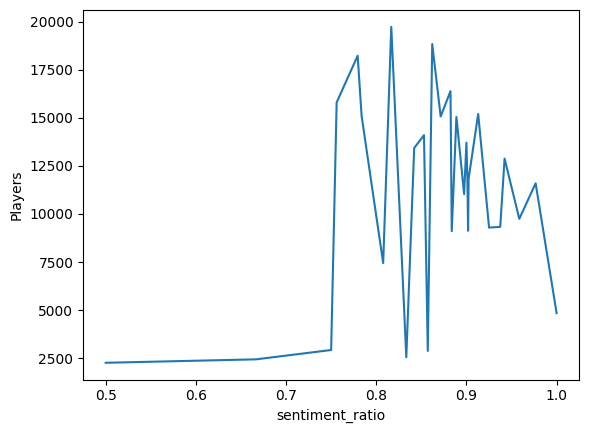

In [54]:
sns.lineplot(data=df_fetch, x='sentiment_ratio', y='Players', ci=None)
plt.show()

C:\Users\alghi\AppData\Local\Temp\ipykernel_27336\2718482762.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_fetch, x='time', y='Players', ci=None)


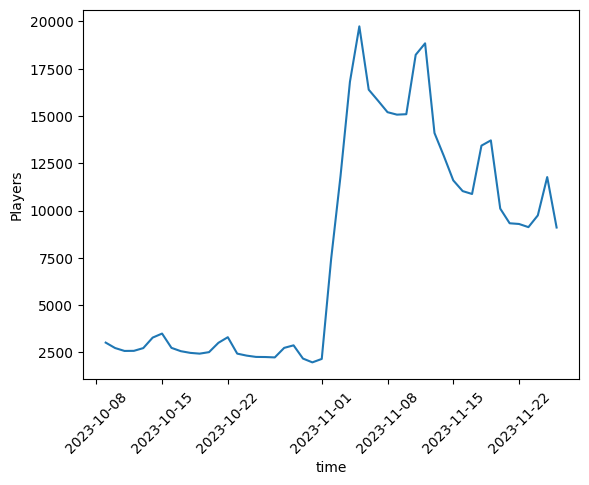

In [55]:
sns.lineplot(data=df_fetch, x='time', y='Players', ci=None)
plt.xticks(rotation=45)
plt.show()

In [56]:
daily_sentiment = df_fetch.set_index('time')[['sentiment_ratio', 'positive_count', 'negative_count', 'Players']].resample('D').mean()

In [98]:
daily_sentiment.to_csv('./data/daily_sentiment.csv', index=True)

comparing sentiment ratio with players count

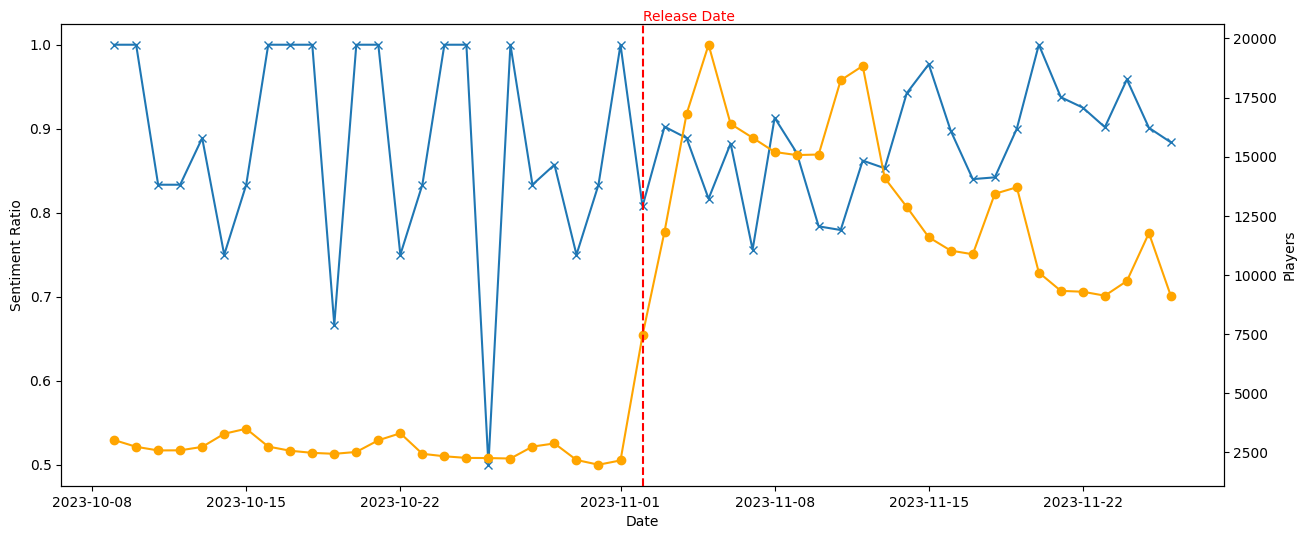

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Tanggal release date
release_date = mdates.datestr2num('2023-11-02')

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_sentiment['sentiment_ratio'].index, daily_sentiment['sentiment_ratio'], marker='x')
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment Ratio')

# Menggabungkan sumbu y
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(daily_sentiment.index, daily_sentiment['Players'], color='orange', marker='o')
ax2.set_ylabel('Players')

# Menambahkan garis vertikal dan teks
plt.axvline(x=release_date, color='red', linestyle='--', label='Release Date')
plt.text(release_date, ax2.get_ylim()[1], 'Release Date', color='red', verticalalignment='bottom', )

plt.xticks(rotation=45)
plt.show()


corellation plot between players and sentiment ratio

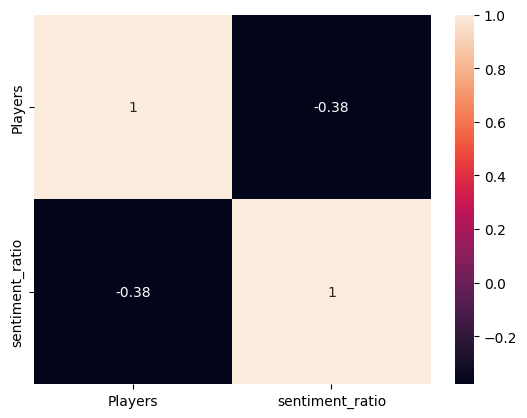

In [48]:
sns.heatmap(df_fetch[['Players', 'sentiment_ratio']].corr(), annot=True)
plt.show()

wordcloud of positive and negative reviews, to get insight of what players like and dislike

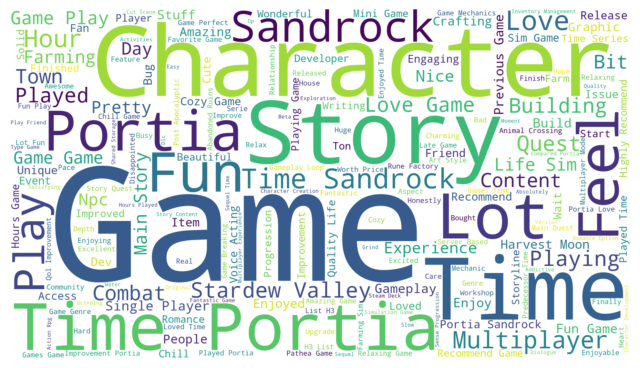

In [101]:
#create wordcloud from positive reviews
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

df_positive = df_fetch[df_fetch['sentiment_label'] == 'POSITIVE']

text = " ".join(review for review in df_positive.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=1920, height=1080).generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./wordcloud_positive.png', dpi=300, format='png')
plt.show()

summarize with lda

In [71]:
df_positive.head()

,time,review,Players,review_clean,sentiment_label,positive,negative,positive_count,negative_count,sentiment_ratio
0,2023-11-08,"i played portia, a while ago. i've had sandroc...",15199,Played Portia Sandrock Radar Intending Multipl...,POSITIVE,1,0,42,4,0.913043
1,2023-11-04,came into sandrock as a big my time at portia ...,16806,Sandrock Time Portia Aficionado Fans Lot Love ...,POSITIVE,1,0,56,7,0.888889
2,2023-11-16,"[h1] dude, where'd my time go? [/h1]\n\n[b] wh...",11028,H1 Dude Time H1 Decent Gameplay Loop Feel Days...,POSITIVE,1,0,35,4,0.897436
3,2023-11-26,this is the best game ever. can't seem to stop...,9102,Game Playing Story Absolute Feels Unique Games...,POSITIVE,1,0,76,10,0.883721
4,2023-11-26,"if you enjoyed the first game in this series, ...",9102,Enjoyed Game Series Love Graphically Beautiful...,POSITIVE,1,0,76,10,0.883721


In [72]:
import spacy
# Inisialisasi spaCy untuk lemmatization
nlp = spacy.load('en_core_web_trf')

# Fungsi tokenizer dan lemmatizer
def spacy_tokenizer(doc):
    return [token.lemma_ for token in nlp(doc) if not token.is_stop]

In [73]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Vectorize teks
vectorizer = CountVectorizer(max_df=0.85, min_df=10, stop_words='english', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
data_vectorized = vectorizer.fit_transform(df_positive['review_clean'])

# Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(data_vectorized)

# Fungsi untuk menampilkan topik
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Menampilkan topik
display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

C:\Users\alghi\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Topic 0:
game feel character sandrock story time portia combat quest play
Topic 1:
game play time story character multiplayer hour sandrock player fun
Topic 2:
game character time love lot play story sandrock life event
Topic 3:
game portia time time portia fun love sandrock lot enjoy story
Topic 4:
game time character story feel lot portia commission item play


In [96]:
df_positive.to_csv('./data/positive_reviews.csv', index=False)

In [74]:
topik_distribution = lda_model.transform(data_vectorized)

topic_texts = {i: [] for i in range(lda_model.n_components)}

for i, distribution in enumerate(topik_distribution):
    topic = np.argmax(distribution)
    text = df_positive['review_clean'].iloc[i]
    topic_texts[topic].append(text)

In [75]:
model_summary = 'facebook/bart-large-cnn'
summary = pipeline('summarization', model=model_summary, tokenizer=model_summary, truncation=True, device=0)

C:\Users\alghi\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alghi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [76]:
summaries = {}

for topic_id, texts in topic_texts.items():
    # assign all the texts into one string variable
    text = '. '.join(texts)
    summary_result = summary(text, min_length=5, max_length=100, do_sample=False)

    summaries[topic_id] = summary_result

In [77]:
summaries

{0: [{'summary_text': 'Stardew Valley Coral Island Portia Harvest Moon Farmer Builder Post Apocalyptic Cute Ish Gather Resources Build Stuff Main Quests Commisions Time Gifts Slowly Win Hearth Sandrockers Unlocking Personal Stories Unfolding Story Sandrock Pros Sandrock Cosy Gameplay Sandrock Grinding Game Happen Extra Caves Resources Wait Ingots Smelt Tedious Story Improvement Portia Story Nice Couple Twist Incredible Surprise Series Townies Stories Compared Portia Entertaining Lots Hours Gameplay Replayable'}],
 1: [{'summary_text': 'Stardew Valley Minecraft Kinda Pick Job Meet House Base Start Day Spend Middle Sandrock Op Bounties Op Forms Ruins Hunt Treasure Op Dungeons Raid Tokens Timed Scored Time Max Skill Tree Start Dipping Drop Nature Game People Lot Hit Ground Feet Running Tons Jobs Build Coma Friends Townsfolk Rich Urban Planning Mechanic Twist Ranching Store Online Earlier Time Unlocked Ranching Late Tree Existed Yak Hair Fun.'}],
 2: [{'summary_text': 'Sandrock Time Portia

wordcloud negatif label

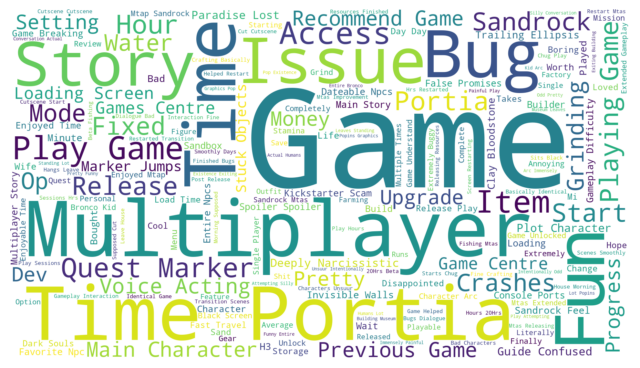

In [100]:
df_negative = df_fetch[df_fetch['sentiment_label'] == 'NEGATIVE']


text = " ".join(review for review in df_negative.review_clean)

wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=1920, height=1080).generate(text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./wordcloud_negative.png', dpi=300, format='png')
plt.show()


### summarize with lda

In [97]:
df_negative.to_csv('./data/negative_reviews.csv', index=False)

In [79]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
import re

# Vectorize teks
vectorizer = CountVectorizer(max_df=0.85, min_df=10, stop_words='english', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
data_vectorized = vectorizer.fit_transform(df_negative['review_clean'])

# Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(data_vectorized)

# Fungsi untuk menampilkan topik
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Menampilkan topik
display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
game time day bug teleport play workshop bad quest mtap
Topic 1:
game play issue fun release time loading wait access load
Topic 2:
game portia time bug story hour time portia progress main play
Topic 3:
game multiplayer sandrock dev npc content player story update miss
Topic 4:
feel game quest character time town lot location complete design


In [80]:
topik_distribution = lda_model.transform(data_vectorized)

topic_texts = {i: [] for i in range(lda_model.n_components)}

for i, distribution in enumerate(topik_distribution):
    topic = np.argmax(distribution)
    text = df_negative['review_clean'].iloc[i]
    topic_texts[topic].append(text)

In [81]:
model_summary = 'facebook/bart-large-cnn'
summary = pipeline('summarization', model=model_summary, tokenizer=model_summary, truncation=True, device=0)

In [82]:
summaries = {}

for topic_id, texts in topic_texts.items():
    # assign all the texts into one string variable
    text = '. '.join(texts)
    summary_result = summary(text, min_length=5, max_length=100, do_sample=False)

    summaries[topic_id] = summary_result

In [83]:
summaries

{0: [{'summary_text': 'Time Portia Mtap Sandrock Mtas Extended Gameplay Interaction Fine Crafting Basically Identical Game Post Release Play 90 Hours 20Hrs Beta Fishing Mtas Improvement Game Bugs Game Starts Chug Play Sessions 5 Hrs Restarted Transition Scenes Smoothly Days Game Hangs Leave House Morning Supposed Cut Cutscene Cutscene Start Game Sits Black Screen Restarting Game Helped Restart Mtas Releasing Resources Finished Bugs Dialogue Bad Characters Unsuur Intentionally Odd Pretty Funny'}],
 1: [{'summary_text': 'Game Review: Game Announced Enjoy Studio Care Western Themed Games Type Music Play Wife Severe Multiplayer B0Rk Game Wonderful Game Fair Monetization Glad Supported Purchasing Personal Disinterest Themes Music Mentioned Recommend Game Understand Purely Personal Taste Disappointment Limited Multiplayer Actual Content Hope Personally Considerably Multiplayer Features Fantastic Single Player Game Promises Op Understand Reasons Difficult Game Development Hope Game Studio Suc